# Google ColaboratoryでChainerのチュートリアルを実行してみる

今回実行するのは、Chainerのドキュメントにある
[MNIST using Trainer](https://docs.chainer.org/en/stable/examples/mnist.html)
を実行する。

In [0]:
# Google Driveにログを出力するために、マウントする
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# デフォルトでインストールされているchainerの情報を出力する
import chainer
chainer.print_runtime_info()

Platform: Linux-4.14.79+-x86_64-with-Ubuntu-18.04-bionic
Chainer: 5.0.0
NumPy: 1.14.6
CuPy:
  CuPy Version          : 5.2.0
  CUDA Root             : /usr/local/cuda
  CUDA Build Version    : 10000
  CUDA Driver Version   : 10000
  CUDA Runtime Version  : 10000
  cuDNN Build Version   : 7301
  cuDNN Version         : 7301
  NCCL Build Version    : 2307
iDeep: 2.0.0.post3


In [0]:
# ライブラリのインポート
import numpy as np
from chainer import backend
from chainer import backends
from chainer.backends import cuda
from chainer import Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions

In [0]:
# データセットの準備
from chainer.datasets import mnist

train, test = mnist.get_mnist()

In [0]:
# イテレーションの準備
batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
test_iter = iterators.SerialIterator(test, batchsize, False, False)

In [0]:
# モデルの定義
class MLP(Chain):

    def __init__(self, n_mid_units=100, n_out=10):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_mid_units)
            self.l2 = L.Linear(None, n_mid_units)
            self.l3 = L.Linear(None, n_out)

    def forward(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

gpu_id = 0  # Set to -1 if you use CPU

model = MLP()
if gpu_id >= 0:
    model.to_gpu(gpu_id)

In [0]:
# Updaterの準備
max_epoch = 10

model = L.Classifier(model)

optimizer = optimizers.MomentumSGD()
optimizer.setup(model)

updater = training.updaters.StandardUpdater(train_iter, optimizer, device=gpu_id)

In [0]:
# Trainerの準備
# logの出力先は、マウントしたGoogle Drive配下とする
trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='/content/gdrive/My Drive/Colab Notebooks/logs/mnist_result')

In [0]:
# Extensionsの追加
trainer.extend(extensions.LogReport())
trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
trainer.extend(extensions.snapshot_object(model.predictor, filename='model_epoch-{.updater.epoch}'))
trainer.extend(extensions.Evaluator(test_iter, model, device=gpu_id))
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
trainer.extend(extensions.dump_graph('main/loss'))

In [0]:
# 実行
trainer.run()

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           0.535992    0.853445       0.264507              0.922172                  3.1307        
2           0.234977    0.93157        0.189933              0.945411                  6.81666       
3           0.180527    0.946595       0.166852              0.950257                  10.5014       
4           0.146536    0.957031       0.130812              0.960146                  14.2928       
5           0.122451    0.964486       0.117694              0.96519                   18.0087       
6           0.105051    0.969067       0.104251              0.968948                  21.7247       
7           0.0911564   0.973064       0.0972288             0.970332                  25.4107       
8           0.0818678   0.975928       0.0968308             0.969937                  29.0969       
9           0.0717192   0.978945       0.0859693             0.974189               

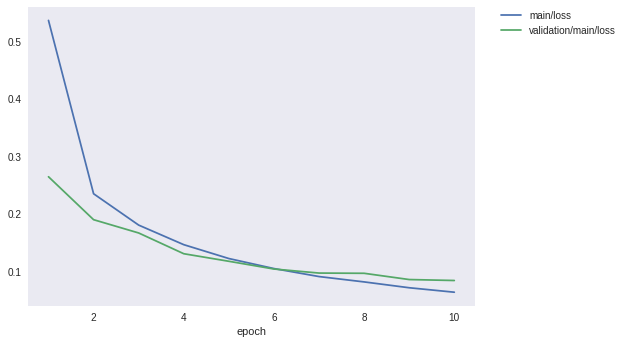

In [0]:
# lossの確認
from IPython.display import Image
Image('/content/gdrive/My Drive/Colab Notebooks/logs/mnist_result/loss.png')

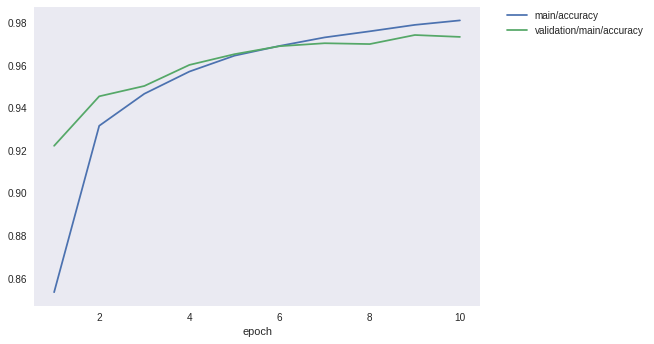

In [0]:
# accuracyの確認
Image('/content/gdrive/My Drive/Colab Notebooks/logs/mnist_result/accuracy.png')